In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier



In [109]:
# Set a random state
np.random.RandomState(1234)

In [110]:
Breast_Cancer = pd.read_csv('Breast Cancer Wisconsin (Diagnostic) Data Set.csv')
Breast_Cancer = Breast_Cancer.replace('B', 'Benign')
Breast_Cancer = Breast_Cancer.replace('M', 'Malignant')
Breast_Cancer = Breast_Cancer.iloc[:, 1:-1]
Breast_Cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,Malignant,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,Malignant,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,Malignant,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,Malignant,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,Malignant,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [111]:
Breast_Cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 n

In [112]:
# Create a new dataframe that includes only our modeling columns 
Breast_Cancer_Model = Breast_Cancer[['diagnosis', 'concave points_mean', 'radius_se', 'texture_worst', 'symmetry_worst']]
Breast_Cancer_Model.shape


(569, 5)

In [113]:
Breast_Cancer_Model.corr()

,concave points_mean,radius_se,texture_worst,symmetry_worst
concave points_mean,1.000000,0.698050,0.292752,0.375744
radius_se,0.698050,1.000000,0.194799,0.094543
texture_worst,0.292752,0.194799,1.000000,0.233027
symmetry_worst,0.375744,0.094543,0.233027,1.000000


In [114]:
# create X matrix and y vector from columns 
X = Breast_Cancer_Model.drop(columns='diagnosis')
y = Breast_Cancer_Model['diagnosis']
y = y.replace('Benign', 0)
y = y.replace('Malignant', 1)
print(X.shape, y.shape)

(569, 4) (569,)


In [115]:
std_scale = StandardScaler()
X = std_scale.fit_transform(X)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [117]:
# std_scale = StandardScaler()
# X_train = std_scale.fit_transform(X_train)
# X_test = std_scale.fit_transform(X_test)
# y_train = std_scale.fit_transform(y_train)
# y_test = std_scale.fit_transform(y_test)

Text(0, 0.5, 'Cross-Validated Recall')

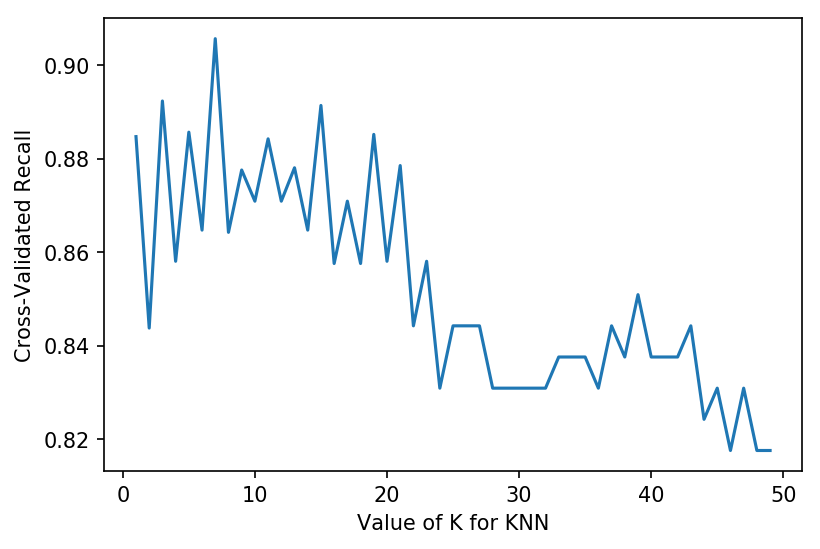

In [118]:
# now try with k-fold = 10 (cv parameter)
k_range = list(range(1, 50))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='recall')
    k_scores.append(scores.mean())

plt.figure(dpi=150)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Recall')

In [119]:
# define the parameter values that should be searched
k_range = list(range(1, 50))

In [120]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}


In [121]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='recall')

In [122]:
# fit the grid with data
grid.fit(X_train, y_train);

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [123]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9059583632447954
{'n_neighbors': 7}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')


In [124]:
# fit on train
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# test on test
y_pred = knn.predict(X_test)

knn_accuracy = metrics.accuracy_score(y_test, y_pred)
knn_recall = metrics.recall_score(y_test, y_pred)
print('kNN Accuracy: {}'.format(knn_accuracy))
print('kNN Recall: {}'.format(knn_recall))

kNN Accuracy: 0.9239766081871345
kNN Recall: 0.873015873015873


In [125]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
knn_confusion

array([[101,   7],
       [  6,  57]])

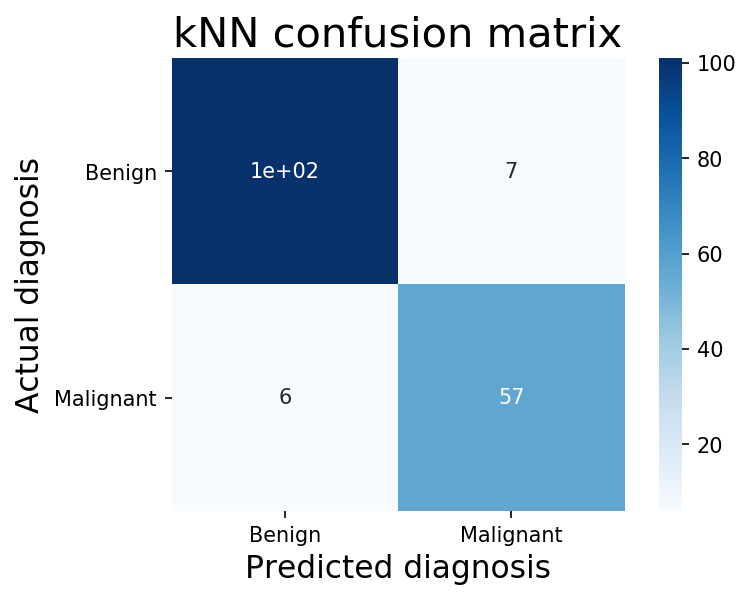

In [126]:
# Print confusion matrix for kNN
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
plt.figure(dpi=150)
cm = sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
cm.set_yticklabels(labels = ['Benign', 'Malignant'], rotation=0)

plt.xlabel('Predicted diagnosis', fontsize=15)
plt.ylabel('Actual diagnosis', fontsize=15)
plt.title('kNN confusion matrix', fontsize=20);

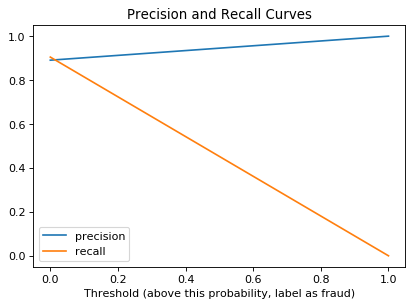

In [127]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, knn.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [128]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(X_test)[:,1])

KNN ROC AUC score =  0.919973544973545


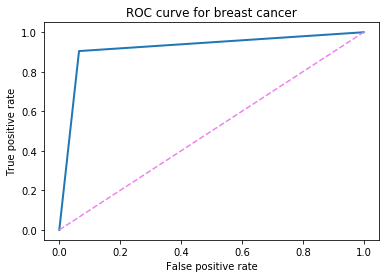

In [129]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for breast cancer');
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))

Text(0, 0.5, 'Cross-Validated Recall')

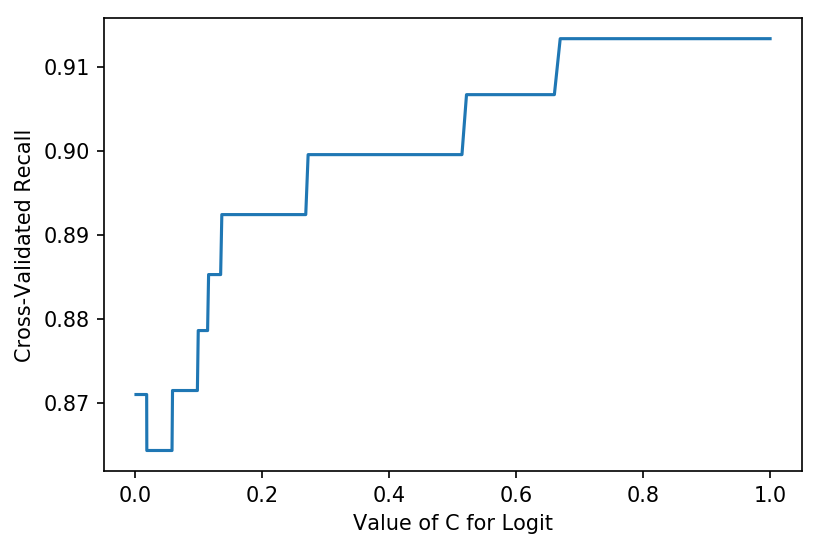

In [130]:
# now try with k-fold = 10 (cv parameter)
C_range = list(10**np.linspace(-3,0,500))
C_scores = []
for i in C_range:
    lm = LogisticRegression(solver= 'liblinear', C=i)
    scores = cross_val_score(lm, X_train, y_train, cv=10, scoring='recall')
    C_scores.append(scores.mean())

plt.figure(dpi=150)
plt.plot(C_range, C_scores)
plt.xlabel('Value of C for Logit')
plt.ylabel('Cross-Validated Recall')

In [131]:
# define the parameter values that should be searched
C_range = list(10**np.linspace(-3,0,1000))

In [132]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_range)

In [133]:
# instantiate the grid
grid = GridSearchCV(lm, param_grid, cv=10, scoring='recall')

In [134]:
# fit the grid with data
grid.fit(X_train, y_train);

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [135]:
# examine the best model
lm1_best_score = grid.best_score_
lm1_best_params_ = grid.best_params_
lm1_best_estimator_ = grid.best_estimator_
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9128978224455611
{'C': 0.6650018030431118}
LogisticRegression(C=0.6650018030431118, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [201]:
# fit on train
lm1 = LogisticRegression(solver='liblinear', C=0.6650018030431118)
lm1.fit(X_train, y_train)

# test on test
y_pred = lm1.predict(X_test)

lm_accuracy = metrics.accuracy_score(y_test, y_pred)
lm_recall = metrics.recall_score(y_test, y_pred)
print('Logistic Regression Accuracy: {}'.format(lm_accuracy))
print('Logistic Regression Recall: {}'.format(lm_recall))

Logistic Regression Accuracy: 0.9298245614035088
Logistic Regression Recall: 0.9206349206349206


In [202]:
lm1.fit(X_train, y_train)
lm1_confusion = confusion_matrix(y_test, lm1.predict(X_test))
lm1_confusion

array([[101,   7],
       [  5,  58]])

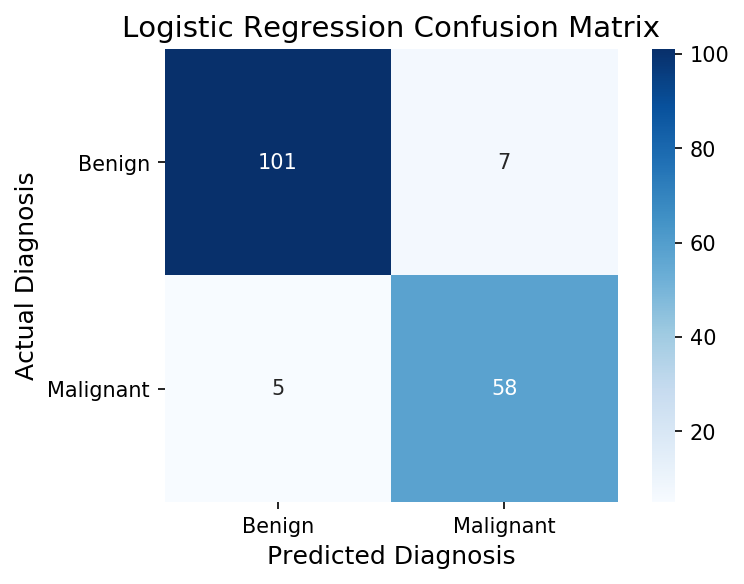

In [256]:
# Print confusion matrix for kNN
lm1_confusion = confusion_matrix(y_test, lm1.predict(X_test))
plt.figure(dpi=150)
cm = sns.heatmap(lm1_confusion, cmap=plt.cm.Blues, annot=True, fmt = 'd', square=True,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
cm.set_yticklabels(labels = ['Benign', 'Malignant'], rotation=0)

plt.xlabel('Predicted Diagnosis', fontsize=12)
plt.ylabel('Actual Diagnosis', fontsize=12)
plt.title('Logistic Regression Confusion Matrix', fontsize=14);

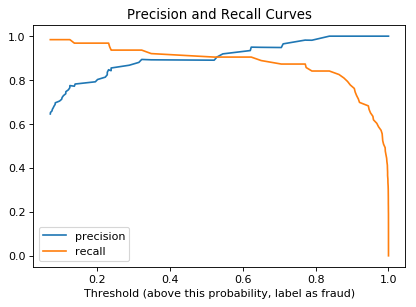

In [139]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm1.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [140]:
Breast_Cancer_Model['concave points_mean'].max()

0.2012

In [141]:
Breast_Cancer_Model['radius_se'].max()

2.873

In [142]:
Breast_Cancer_Model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 5 columns):
diagnosis              569 non-null object
concave points_mean    569 non-null float64
radius_se              569 non-null float64
texture_worst          569 non-null float64
symmetry_worst         569 non-null float64
dtypes: float64(4), object(1)
memory usage: 22.3+ KB


In [143]:
Breast_Cancer_Model['diagnosis'] = (Breast_Cancer_Model['diagnosis'] != 'Benign').astype(int)

/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [144]:
Breast_Cancer_Model.diagnosis.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


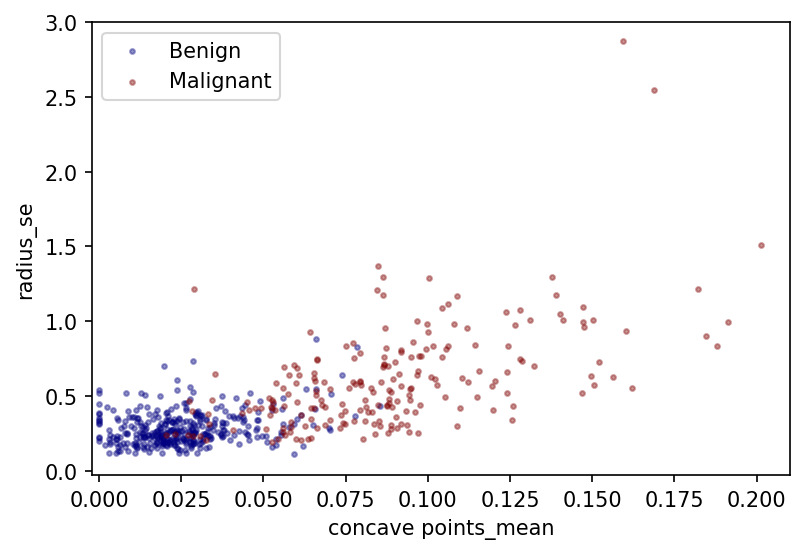

In [145]:
def scatter_plot_data(data):
    plt.figure(dpi=150)
    for i, label in enumerate(['Benign','Malignant']):
        new_data = data[data['diagnosis']==i]
        plt.scatter(new_data['concave points_mean'], new_data['radius_se'],c=plt.cm.jet(i/0.5), alpha=0.4, label=label, s=5)
    plt.ylabel("radius_se")
    plt.xlabel("concave points_mean")
    plt.ylim(-.03, 3) 
    plt.xlim(-.0021, 0.21) 
    plt.legend(loc="upper left");

scatter_plot_data(Breast_Cancer_Model)


In [148]:
Diagnosis = Breast_Cancer_Model.iloc[:, 1:]
Features = Breast_Cancer_Model.iloc[:, :1]

In [107]:
X.head()

,0,1,2,3,4,5,6,7
0,2.532475,2.489734,-1.359293,2.750622,2.487578,0.660820,1.886690,2.001237
1,0.548144,0.499255,-0.369203,-0.243890,0.742402,0.260162,1.805927,1.890489
2,2.037231,1.228676,-0.023974,1.152255,1.181336,1.424827,1.511870,1.456285
3,1.451707,0.326373,0.133984,6.046041,-0.288378,1.115007,-0.281464,-0.550021
4,1.428493,1.270543,-1.466770,-0.868353,1.190357,1.144205,1.298575,1.220724


In [38]:
fpr_lm, tpr_lm, thresholds_lm = roc_curve(y_test, lm1.predict_proba(X_test)[:,1])

KNN ROC AUC score =  0.919973544973545
LM ROC AUC score =  0.9858906525573192


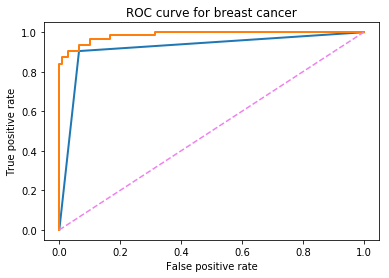

In [39]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_lm, tpr_lm,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for breast cancer');
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print("LM ROC AUC score = ", roc_auc_score(y_test, lm1.predict_proba(X_test)[:,1]))

In [40]:
# fit on train
nb = GaussianNB()
nb.fit(X_train, y_train)

# test on test
y_pred = nb.predict(X_test)

nb_accuracy = metrics.accuracy_score(y_test, y_pred)
nb_recall = metrics.recall_score(y_test, y_pred)
print('Naive Bayes Accuracy: {}'.format(nb_accuracy))
print('Naive Bayes Recall: {}'.format(nb_recall))

Naive Bayes Accuracy: 0.9005847953216374
Naive Bayes Recall: 0.8571428571428571


In [41]:
nb.fit(X_train, y_train)
nb_confusion = confusion_matrix(y_test, nb.predict(X_test))
nb_confusion

array([[100,   8],
       [  9,  54]])

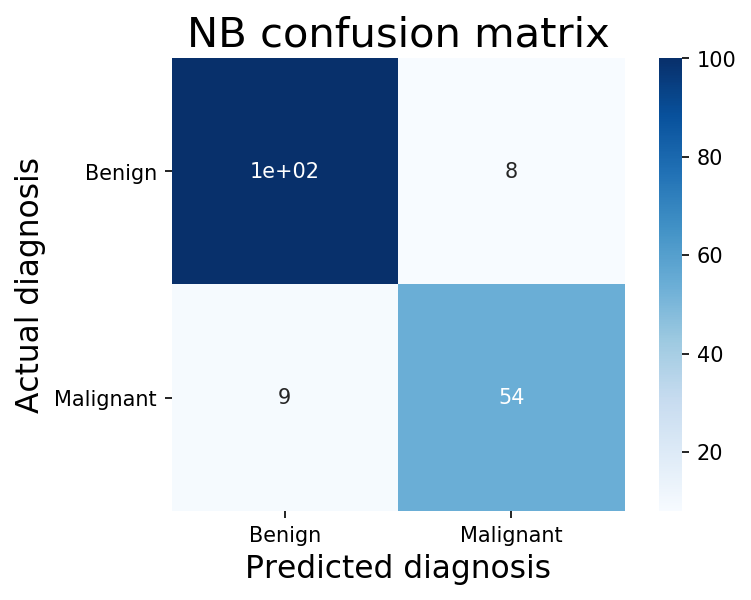

In [42]:
# Print confusion matrix for kNN
nb_confusion = confusion_matrix(y_test, nb.predict(X_test))
plt.figure(dpi=150)
cm = sns.heatmap(nb_confusion, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
cm.set_yticklabels(labels = ['Benign', 'Malignant'], rotation=0)

plt.xlabel('Predicted diagnosis', fontsize=15)
plt.ylabel('Actual diagnosis', fontsize=15)
plt.title('NB confusion matrix', fontsize=20);

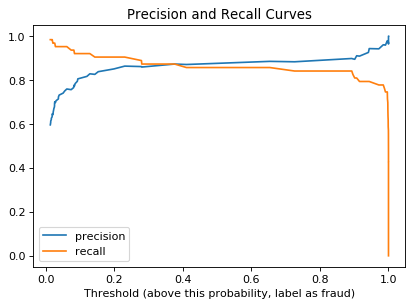

In [43]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, nb.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [44]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb.predict_proba(X_test)[:,1])

KNN ROC AUC score =  0.919973544973545
LM ROC AUC score =  0.9858906525573192
NB ROC AUC score =  0.9666372721928278


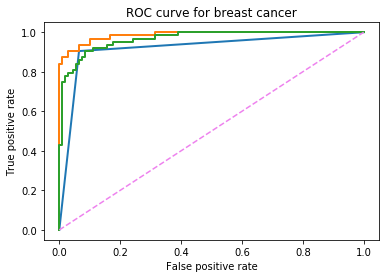

In [45]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_lm, tpr_lm,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for breast cancer');
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print("LM ROC AUC score = ", roc_auc_score(y_test, lm1.predict_proba(X_test)[:,1]))
print("NB ROC AUC score = ", roc_auc_score(y_test, nb.predict_proba(X_test)[:,1]))

In [46]:
# fit on train
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)

# test on test
y_pred = decisiontree.predict(X_test)

decisiontree_accuracy = metrics.accuracy_score(y_test, y_pred)
decisiontree_recall = metrics.recall_score(y_test, y_pred)
print('Decision Tree Accuracy: {}'.format(decisiontree_accuracy))
print('Decision Tree Recall: {}'.format(decisiontree_recall))

Decision Tree Accuracy: 0.9064327485380117
Decision Tree Recall: 0.8888888888888888


In [47]:
decisiontree.fit(X_train, y_train)
decisiontree_confusion = confusion_matrix(y_test, decisiontree.predict(X_test))
decisiontree_confusion

array([[98, 10],
       [ 7, 56]])

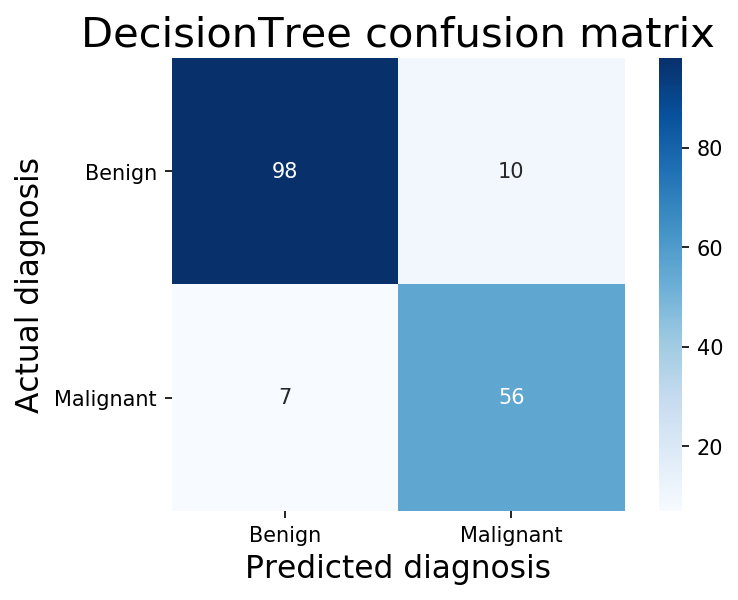

In [48]:
# Print confusion matrix for kNN
decisiontree_confusion = confusion_matrix(y_test, decisiontree.predict(X_test))
plt.figure(dpi=150)
cm = sns.heatmap(decisiontree_confusion, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
cm.set_yticklabels(labels = ['Benign', 'Malignant'], rotation=0)

plt.xlabel('Predicted diagnosis', fontsize=15)
plt.ylabel('Actual diagnosis', fontsize=15)
plt.title('DecisionTree confusion matrix', fontsize=20);

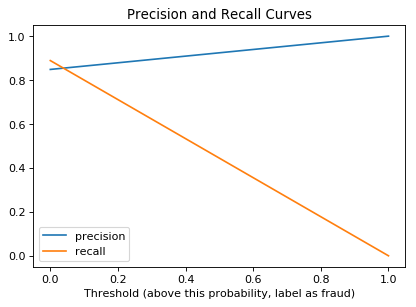

In [49]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, decisiontree.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');


In [50]:
fpr_decisiontree, tpr_decisiontree, thresholds_decisiontree = roc_curve(y_test, decisiontree.predict_proba(X_test)[:,1])


KNN ROC AUC score =  0.919973544973545
LM ROC AUC score =  0.9858906525573192
NB ROC AUC score =  0.9666372721928278
DecisionTree ROC AUC score =  0.8981481481481481


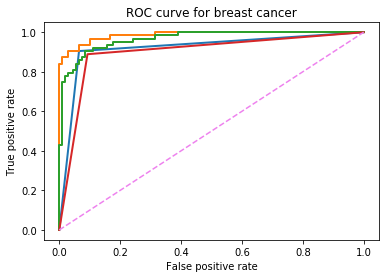

In [51]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_lm, tpr_lm,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_decisiontree, tpr_decisiontree,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for breast cancer');
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print("LM ROC AUC score = ", roc_auc_score(y_test, lm1.predict_proba(X_test)[:,1]))
print("NB ROC AUC score = ", roc_auc_score(y_test, nb.predict_proba(X_test)[:,1]))
print("DecisionTree ROC AUC score = ", roc_auc_score(y_test, decisiontree.predict_proba(X_test)[:,1]))

Text(0, 0.5, 'Cross-Validated Recall')

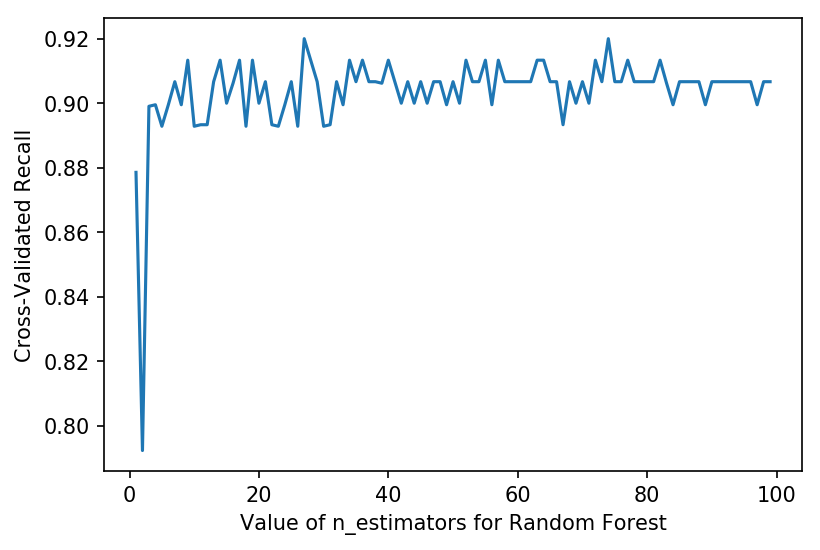

In [52]:
# random forest with k-fold = 10 (cv parameter)
n_estimators_range = list(range(1, 100))
n_estimators_scores = []
for i in n_estimators_range:
    randomforest = RandomForestClassifier(n_estimators=i)
    scores = cross_val_score(randomforest, X_train, y_train, cv=10, scoring='recall')
    n_estimators_scores.append(scores.mean())

plt.figure(dpi=150)
plt.plot(n_estimators_range, n_estimators_scores)
plt.xlabel('Value of n_estimators for Random Forest')
plt.ylabel('Cross-Validated Recall')

In [53]:
# define the parameter values that should be searched
n_estimators_range = list(range(1, 100))

In [54]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_estimators=n_estimators_range)

In [55]:
# instantiate the grid
grid = GridSearchCV(randomforest, param_grid, cv=10, scoring='recall')

In [56]:
# fit the grid with data
grid.fit(X_train, y_train);

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [57]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9195979899497487
{'n_estimators': 41}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [58]:
# fit on train
randomforest = RandomForestClassifier(n_estimators=11)
randomforest.fit(X_train, y_train)

# test on test
y_pred = randomforest.predict(X_test)

randomforest_accuracy = metrics.accuracy_score(y_test, y_pred)
randomforest_recall = metrics.recall_score(y_test, y_pred)
print('Random Forest Accuracy: {}'.format(randomforest_accuracy))
print('Random Forest Recall: {}'.format(randomforest_recall))

Random Forest Accuracy: 0.9298245614035088
Random Forest Recall: 0.8888888888888888


In [59]:
randomforest.fit(X_train, y_train)
randomforest.fit(X_train, y_train)
randomforest_confusion = confusion_matrix(y_test, randomforest.predict(X_test))
randomforest_confusion

array([[104,   4],
       [  8,  55]])

In [243]:
np.set_printoptions(suppress=True)


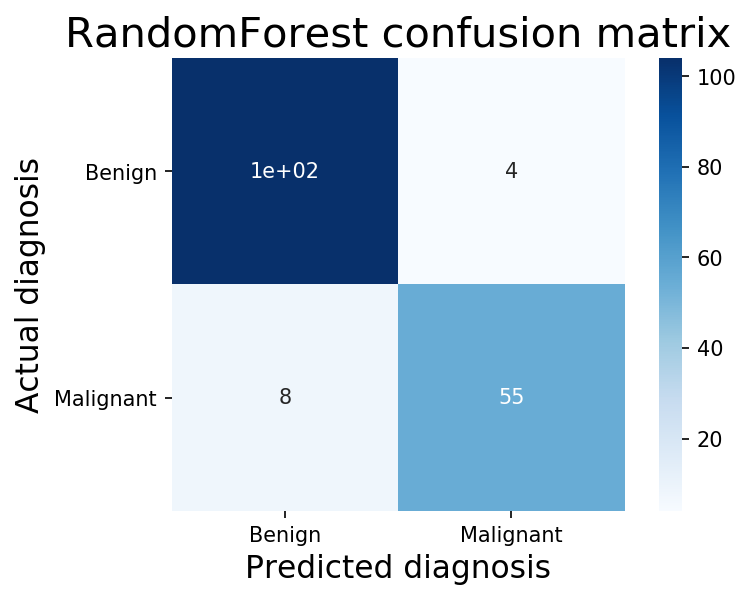

In [244]:
# Print confusion matrix for kNN
randomforest_confusion = confusion_matrix(y_test, randomforest.predict(X_test))
plt.figure(dpi=150)
cm = sns.heatmap(randomforest_confusion, cmap=plt.cm.Blues, annot=True, square=True,
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
cm.set_yticklabels(labels = ['Benign', 'Malignant'], rotation=0)

plt.xlabel('Predicted diagnosis', fontsize=15)
plt.ylabel('Actual diagnosis', fontsize=15)
plt.title('RandomForest confusion matrix', fontsize=20);

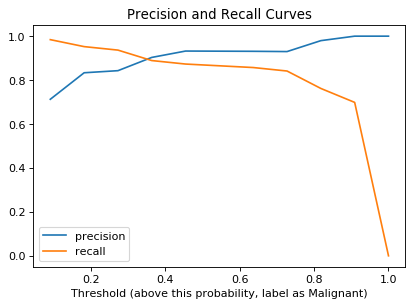

In [258]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, randomforest.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Malignant)');
plt.title('Precision and Recall Curves');


In [62]:
fpr_randomforest, tpr_randomforest, thresholds_randomforest = roc_curve(y_test, decisiontree.predict_proba(X_test)[:,1])


KNN ROC AUC score =  0.919973544973545
LM ROC AUC score =  0.9858906525573192
NB ROC AUC score =  0.9666372721928278
DecisionTree ROC AUC score =  0.8981481481481481
RandomForest ROC AUC score =  0.9797912992357437


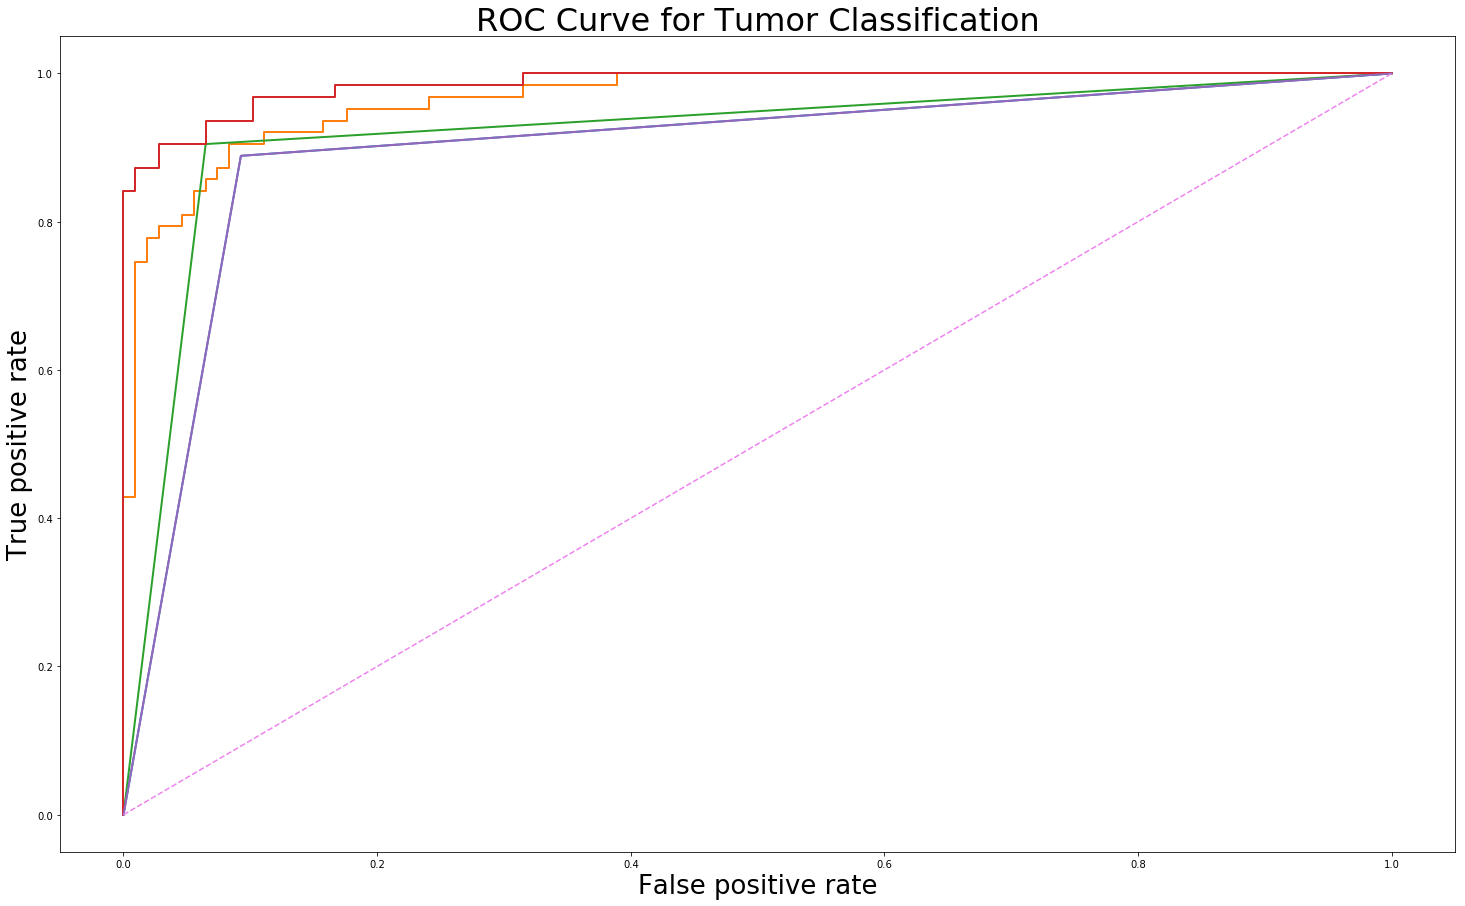

In [238]:
plt.figure(figsize=(25,15))
plt.plot(fpr_decisiontree, tpr_decisiontree,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_lm, tpr_lm,lw=2)
plt.plot(fpr_randomforest, tpr_randomforest,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate', size=26)
plt.ylabel('True positive rate', size=26)
plt.title('ROC Curve for Tumor Classification', size=32);
print("KNN ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print("LM ROC AUC score = ", roc_auc_score(y_test, lm1.predict_proba(X_test)[:,1]))
print("NB ROC AUC score = ", roc_auc_score(y_test, nb.predict_proba(X_test)[:,1]))
print("DecisionTree ROC AUC score = ", roc_auc_score(y_test, decisiontree.predict_proba(X_test)[:,1]))
print("RandomForest ROC AUC score = ", roc_auc_score(y_test, randomforest.predict_proba(X_test)[:,1]))

In [64]:
print('kNN Accuracy: {}'.format(knn_accuracy))
print('Logistic Regression Accuracy: {}'.format(lm_accuracy))
print('Naive Bayes Accuracy: {}'.format(nb_accuracy))
print('Decision Tree Accuracy: {}'.format(decisiontree_accuracy))
print('Random Forest Accuracy: {}'.format(randomforest_accuracy))

kNN Accuracy: 0.9239766081871345
Logistic Regression Accuracy: 0.9298245614035088
Naive Bayes Accuracy: 0.9005847953216374
Decision Tree Accuracy: 0.9064327485380117
Random Forest Accuracy: 0.9298245614035088


In [65]:
print('kNN Recall: {}'.format(knn_recall))
print('Logistic Regression Recall: {}'.format(lm_recall))
print('Naive Bayes Recall: {}'.format(nb_recall))
print('Decision Tree Recall: {}'.format(decisiontree_recall))
print('Random Forest Recall: {}'.format(randomforest_recall))

kNN Recall: 0.873015873015873
Logistic Regression Recall: 0.9206349206349206
Naive Bayes Recall: 0.8571428571428571
Decision Tree Recall: 0.8888888888888888
Random Forest Recall: 0.8888888888888888


In [66]:
# So far our logistic regression model had the best recall (Best AUC and second in accuracy behind Random Forest)
# Let's examine other features to see if they can improve our model performance

In [67]:
# Create a new dataframe that includes new feature columns 
Feature_Additions = Breast_Cancer[['area_se', 'concave points_se', 'radius_worst', 'area_worst']]
Breast_Cancer_Model = pd.merge(Breast_Cancer_Model, Feature_Additions, how = 'left', left_index = True, right_index = True)
Breast_Cancer_Model.head()


,diagnosis,concave points_mean,radius_se,texture_worst,symmetry_worst,area_se,concave points_se,radius_worst,area_worst
0,Malignant,0.14710,1.0950,17.33,0.4601,153.40,0.01587,25.38,2019.0
1,Malignant,0.07017,0.5435,23.41,0.2750,74.08,0.01340,24.99,1956.0
2,Malignant,0.12790,0.7456,25.53,0.3613,94.03,0.02058,23.57,1709.0
3,Malignant,0.10520,0.4956,26.50,0.6638,27.23,0.01867,14.91,567.7
4,Malignant,0.10430,0.7572,16.67,0.2364,94.44,0.01885,22.54,1575.0


In [68]:
Breast_Cancer_Model.shape

(569, 9)

In [69]:
Breast_Cancer_Model.corr() # We may have some multicolinearity here.. we will need to address this

,concave points_mean,radius_se,texture_worst,symmetry_worst,area_se,concave points_se,radius_worst,area_worst
concave points_mean,1.000000,0.698050,0.292752,0.375744,0.690299,0.615634,0.830318,0.809630
radius_se,0.698050,1.000000,0.194799,0.094543,0.951830,0.513346,0.715065,0.751548
texture_worst,0.292752,0.194799,1.000000,0.233027,0.196497,0.086741,0.359921,0.345842
symmetry_worst,0.375744,0.094543,0.233027,1.000000,0.074126,0.143116,0.243529,0.209146
area_se,0.690299,0.951830,0.196497,0.074126,1.000000,0.415730,0.757373,0.811408
concave points_se,0.615634,0.513346,0.086741,0.143116,0.415730,1.000000,0.358127,0.342271
radius_worst,0.830318,0.715065,0.359921,0.243529,0.757373,0.358127,1.000000,0.984015
area_worst,0.809630,0.751548,0.345842,0.209146,0.811408,0.342271,0.984015,1.000000


In [83]:
# create X matrix and y vector from columns 
X = Breast_Cancer_Model.drop(columns='diagnosis')
y = Breast_Cancer_Model['diagnosis']
y = y.replace('Benign', 0)
y = y.replace('Malignant', 1)
print(X.shape, y.shape)

(569, 8) (569,)


In [84]:
std_scale = StandardScaler()
X = std_scale.fit_transform(X)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Text(0, 0.5, 'Cross-Validated Recall')

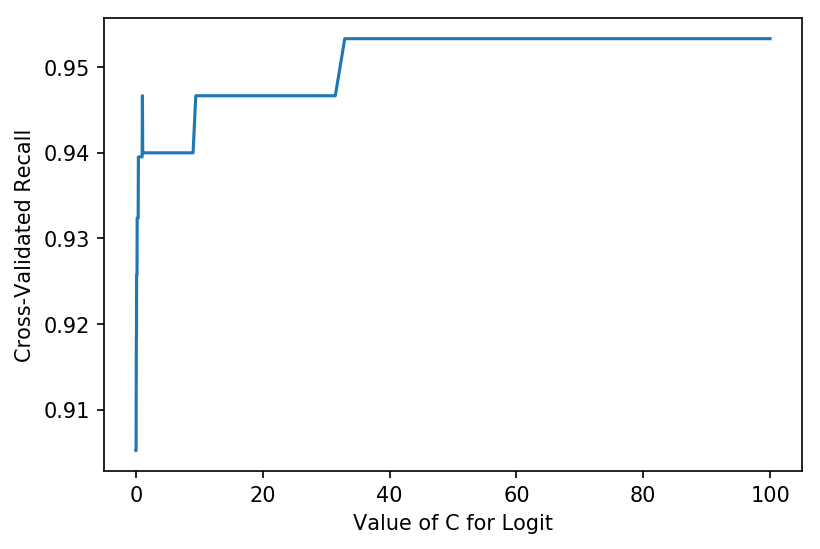

In [86]:
## now try with k-fold = 10 (cv parameter)
C_range = list(10**np.linspace(-2,2,200))
C_scores = []
for i in C_range:
    lm = LogisticRegression(solver= 'liblinear', C=i)
    scores = cross_val_score(lm, X_train, y_train, cv=10, scoring='recall')
    C_scores.append(scores.mean())

plt.figure(dpi=150)
plt.plot(C_range, C_scores)
plt.xlabel('Value of C for Logit')
plt.ylabel('Cross-Validated Recall')

In [87]:
# define the parameter values that should be searched
C_range = list(10**np.linspace(-2,2,1000))

In [88]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_range)

In [89]:
# instantiate the grid
grid = GridSearchCV(lm, param_grid, cv=10, scoring='recall')

In [90]:
# fit the grid with data
grid.fit(X_train, y_train);

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [91]:
# examine the best model
lm2_best_score = grid.best_score_
lm2_best_params_ = grid.best_params_
lm2_best_estimator_ = grid.best_estimator_
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9530988274706867
{'C': 32.47218492073129}
LogisticRegression(C=32.47218492073129, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [92]:
# fit on train
lm2 = LogisticRegression(solver='liblinear', C=32.47218492073129)
lm2.fit(X_train, y_train)

# test on test
y_pred = lm2.predict(X_test)

lm2_accuracy = metrics.accuracy_score(y_test, y_pred)
lm2_recall = metrics.recall_score(y_test, y_pred)
print('Logistic Regression Accuracy: {}'.format(lm_accuracy))
print('Logistic Regression Recall: {}'.format(lm_recall))
print('Logistic Regression 2 Accuracy: {}'.format(lm2_accuracy))
print('Logistic Regression 2 Recall: {}'.format(lm2_recall))

Logistic Regression Accuracy: 0.9298245614035088
Logistic Regression Recall: 0.9206349206349206
Logistic Regression 2 Accuracy: 0.9532163742690059
Logistic Regression 2 Recall: 0.9365079365079365


In [93]:
# Our 2nd Logistic Regression performs slightly better, however, we have multicolinearity...
Breast_Cancer_Model.corr()  # Let's go with lm1

,concave points_mean,radius_se,texture_worst,symmetry_worst,area_se,concave points_se,radius_worst,area_worst
concave points_mean,1.000000,0.698050,0.292752,0.375744,0.690299,0.615634,0.830318,0.809630
radius_se,0.698050,1.000000,0.194799,0.094543,0.951830,0.513346,0.715065,0.751548
texture_worst,0.292752,0.194799,1.000000,0.233027,0.196497,0.086741,0.359921,0.345842
symmetry_worst,0.375744,0.094543,0.233027,1.000000,0.074126,0.143116,0.243529,0.209146
area_se,0.690299,0.951830,0.196497,0.074126,1.000000,0.415730,0.757373,0.811408
concave points_se,0.615634,0.513346,0.086741,0.143116,0.415730,1.000000,0.358127,0.342271
radius_worst,0.830318,0.715065,0.359921,0.243529,0.757373,0.358127,1.000000,0.984015
area_worst,0.809630,0.751548,0.345842,0.209146,0.811408,0.342271,0.984015,1.000000


In [151]:
pip install plotly

     |████████████████████████████████| 41.2MB 3.1MB/s eta 0:00:01
  Stored in directory: /Users/jacob/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [160]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [185]:
Benign = Breast_Cancer_Model[Breast_Cancer_Model['diagnosis'] == 0]
Malignant = Breast_Cancer_Model[Breast_Cancer_Model['diagnosis'] == 1]


In [259]:
x = Breast_Cancer_Model['concave points_mean']
y = Breast_Cancer_Model['radius_se']
z = Breast_Cancer_Model['symmetry_worst']
c = Breast_Cancer_Model['diagnosis']

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
    size=3,
    color=c,
    colorscale=[[0.0, 'rgb(49,54,149)'], [1.0, 'rgb(165,0,38)']],
    opacity=0.25),
    showlegend=False)

data = [trace1]
layout = go.Layout(
    margin=dict(
    l=0,
    r=0, 
    b=0,
    t=0)
)

layout = go.Layout(
    scene = dict(
    xaxis = dict(
        title='Concavity'),
    yaxis = dict(
        title='Radius'),
    zaxis = dict(
        title='Symmetry'),),
    width=700,
    margin=dict(
    r=20, b=10,
    l=10, t=10)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-pubg-plot')
